## Visualizing multiple variables of Gapminder data and assessing goodness of fit on models - part 1

## Objective
* Create an interactive slider plot to show babies per woman vs % children alive at age 5 over the years
* Create an interactive selector plot to show GDP per day vs life expectancy over the years
* Fit and plot models for the babies per woman vs % children alive at age 5 data for the year of 1985
* Compare different models through goodness of fit

In [1]:
# Standard imports
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from IPython import display
from ipywidgets import interact, widgets

Loading gapminder data for year 1985 and setting up plots

In [2]:
gapminder = pd.read_csv('gapminder.csv')

In [3]:
# Create an interactive slider plot to show
# babies per woman vs % children alive at age 5 over the years
def plotyear_slider(year):
    data = gapminder[gapminder.year == year]
    # Make dot size depend on population size
    area = 5e-6 * data.population
    # Use different colors for different regions of the world
    colors = data.region.map({'Africa': '#C8D5F4', 
                              'Europe': '#85E1AD',
                              'America': '#F8C192',
                              'Asia': '#F4BCD7'})
    data.plot.scatter('babies_per_woman', 'age5_surviving',
                      s=area, c=colors, linewidths=1, edgecolors='k', figsize=(12,9))
    plt.axis(ymin=50, ymax=105, xmin=0, xmax=8)
    plt.xlabel('Babies per woman')
    plt.ylabel('% children alive at 5')

In [4]:
interact(plotyear_slider, year=widgets.IntSlider(min=1950,max=2015,step=1,value=1965))

interactive(children=(IntSlider(value=1965, description='year', max=2015, min=1950), Output()), _dom_classes=(…

<function __main__.plotyear_slider(year)>

In [5]:
# Create an interactive selector plot to show
# GDP per day vs life expectancy over the years
def plotyear_select(year):
    data = gapminder[gapminder.year == year].sort_values('population',ascending=False)
    area = 5e-6 * data.population
    color = data.age5_surviving
    edgecolor = data.region.map({'Africa': 'skyblue',
                                 'Europe': 'gold',
                                 'America': 'palegreen',
                                 'Asia': 'coral'})
    data.plot.scatter('gdp_per_day', 'life_expectancy', logx=True, 
                      s=area, c=color,
                      colormap=matplotlib.cm.get_cmap('Purples_r'),
                      vmin=55,
                      vmax=100,
                      linewidths=1,
                      edgecolors=edgecolor,
                      sharex=False,
                      figsize=(10,6.5))
    
    plt.axis(xmin=1, xmax=500, ymin=30, ymax=100)

In [6]:
# Animate with selector
interact(plotyear_select,year=range(1965, 2016, 10))

interactive(children=(Dropdown(description='year', options=(1965, 1975, 1985, 1995, 2005, 2015), value=1965), …

<function __main__.plotyear_select(year)>

In [7]:
# Select data year for model fitting
gdata = gapminder.query('year == 1985')

In [8]:
# Create a basic scatter plot to overlay the fitted models on top of
size = 1e-6 * gdata.population

colors = gdata.region.map({'Africa': 'skyblue', 'Europe': 'gold', 'America': 'palegreen', 'Asia': 'coral'})

def plotdata():
    gdata.plot.scatter('age5_surviving','babies_per_woman',
                      c=colors,s=size,linewidths=0.5,edgecolor='k',alpha=0.5)

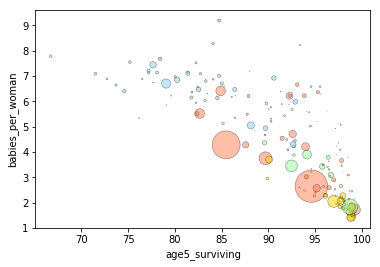

In [9]:
plotdata()

In [10]:
# Setting up function to plot for models
def plotfit(fit):
    plotdata()
    plt.scatter(gdata.age5_surviving,fit.predict(gdata),
               c=colors,s=30,linewidths=0.5,edgecolor='k',marker='D')

## Using Statsmodels to fit models

* Default to OLS method for now
* OSL stands for ordinary least squares
* Least squares means that models are fit by minimizing the sum of squares between model predictions adn observations
* Ordinary means that the model coefficients appear linearly in the model formulas
* Statsmodels lets us specify models by way of the ~ notation; which is also used in R (ex: babies_per_woman ~ age5_surviving)
* Define model and then assign date

In [11]:
grandmean = smf.ols(formula='babies_per_woman ~ 1', data=gdata).fit()  # ~ 1 represents constant

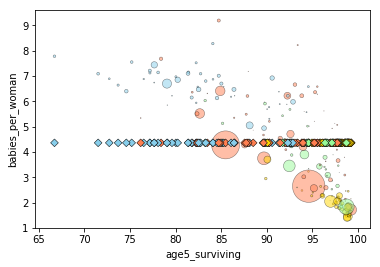

In [12]:
plotfit(grandmean)

In [13]:
grandmean.params

Intercept    4.360714
dtype: float64

In [14]:
gdata.babies_per_woman.mean()

4.360714285714287

The result of this model is equivalent to returning the mean of response variables. Let's compare the fit parameters, which are held in the attribute params of the results object with a simple mean of the data. The constant term is known as the intercept. If we now introduce the region as the model term, we get the model equivalent by taking means by group. TO add a model term, we include it on the right hand side of the formula with a +. To treat all groups in the same way, we write a constant with a minus.

In [15]:
groupmeans = smf.ols(formula='babies_per_woman ~ -1 + region', data=gdata).fit()

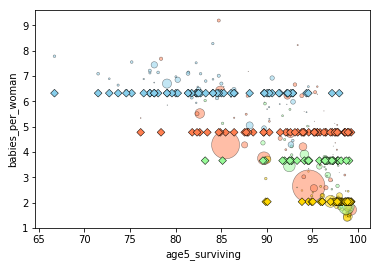

In [16]:
plotfit(groupmeans)

In [17]:
groupmeans.params

region[Africa]     6.321321
region[America]    3.658182
region[Asia]       4.775577
region[Europe]     2.035682
dtype: float64

In [18]:
gdata.groupby('region').babies_per_woman.mean()

region
Africa     6.321321
America    3.658182
Asia       4.775577
Europe     2.035682
Name: babies_per_woman, dtype: float64

Now we try something that we cannot get out of simple means. We add a quantitative variable, child survival, as the main term in the model.

In [19]:
surviving = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving', data=gdata).fit()

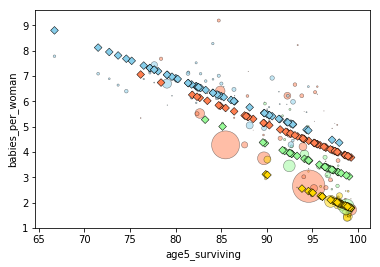

In [20]:
plotfit(surviving)

In [21]:
surviving.params

region[Africa]     18.265792
region[America]    17.085884
region[Asia]       17.864741
region[Europe]     15.872183
age5_surviving     -0.141886
dtype: float64

The fit improves visually. It tells us that for every additional percentage point of child survival to age 5, the number of babies per woman decreased by .14. If we wish to have a different slope for every region, we can throw in an interaction term, as opposed to a main term, which involved 2 explanatory variables. The interaction term is written with a colon. India and China, represented by the large circles, seem to be outliers with respect to the fit. Perhaps we can account for them by including anotehr main term this time proportional to population.

In [22]:
surviving_byregion_population = smf.ols(
    formula='babies_per_woman ~ -1 + region + age5_surviving'
            '+ age5_surviving:region - age5_surviving + population',
    data=gdata).fit()

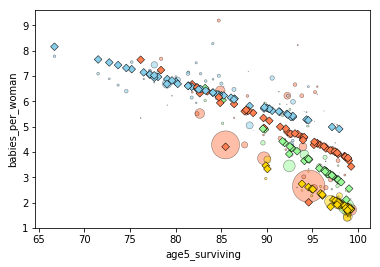

In [23]:
plotfit(surviving_byregion_population)

Now we see that the diamonds don't simply lie along straight lines, because of the population explanatory variable.

## Comparing 2 models
* Surviving: include constant terms for every region + a single main term for age 5 survival
* Surviving by population and region includes the constant terms, a different slope for every region and a main term for population

How can we tell which model is better?

### Let's look at classical measures of goodness of fit
-----
* **Mean squared error of residuals**

* **R squared** ( Maximum = 1; Minimum = 0 )

\begin{equation*}
{R^2} = \frac{Explained \> variance}{(Total \> variance)}
\end{equation*}


* **The F Statistic**: Measures how much, on average, each parameter contributes to the growth of R squared compared to a random model vector. An F of 1 means that the parameter contributes the same as a random vector. Takes into account explained AND unexplained variance AND number of model parameters. Too many parameers will overfit the data, losing predictive power.

* **ANOVA tables**: Analysis of variance. Collects key goodness of fit statistics.

First, plot the actual residuals. This is saved in the StatsModels fit results object. We can do a scatter plot of an explanatory variable against the residuals.



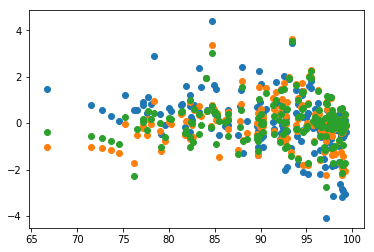

In [24]:
plt.scatter(gdata.age5_surviving, groupmeans.resid)
# Overlay 2 more
plt.scatter(gdata.age5_surviving, surviving.resid)
plt.scatter(gdata.age5_surviving, surviving_byregion_population.resid)

Our best model so far does better than the other ones but not by much. The fit results object contain also the mean square residual, which gives us goodness of fit in a single number. We loop over the 3 models and look at mse_resid for mean squared error.


In [25]:
# Mean squared error
for model in [groupmeans, surviving, surviving_byregion_population]:
    print(model.mse_resid)

1.4979520263709156
0.9423025333008324
0.8480227300570337


In [26]:
# R squared
for model in [groupmeans, surviving, surviving_byregion_population]:
    print(model.rsquared)

0.6364676965596588
0.7726009080146058
0.7999775707885214


In [27]:
# The F statistic
for model in [groupmeans, surviving, surviving_byregion_population]:
    print(model.fvalue)

103.88003937611684
150.34180603430977
86.48787556725169


In [28]:
# StatsModels provides much more!
surviving.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       babies_per_woman   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     150.3
Date:                Tue, 20 Nov 2018   Prob (F-statistic):           8.26e-56
Time:                        21:25:17   Log-Likelihood:                -250.30
No. Observations:                 182   AIC:                             510.6
Df Residuals:                     177   BIC:                             526.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
region[Africa]     18.2658      1.168     15.639      0.000      15.961      20.571
region[America]    17.0859      1.315     12.990      0.000      14.490      19.682
region[Asia]       17.8647      1.279     13.971      0.000      15.341      20.388
region[Europe]     15.8722      1.352     11.739      0.000      13.204      18.541
age5_surviving     -0.1419      0.014    -10.294      0.000      -0.169      -0.115
==============================================================================
Omnibus:                       13.021   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               18.362
Skew:                           0.443   Prob(JB):                     0.000103
Kurtosis:                       4.279   Cond. No.                     3.25e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
# ANOVA table for groupmeans model
sm.stats.anova_lm(groupmeans)

,df,sum_sq,mean_sq,F,PR(>F)
region,4.0,3927.702839,981.925710,655.512121,2.604302e-105
Residual,178.0,266.635461,1.497952,NaN,NaN


The first column shows the degree of freedom (# of parameters); For the residual, the # of data points - # of parameters. The sum squared and mean squared columns show the total and average explained in residual variance. The last column is the P value for a known model with the same # of parameters as ours but where the terms are random. The very high F statistic explains the high variance of data. 

In [30]:
# ANOVA table for groupmeans model
sm.stats.anova_lm(surviving)

,df,sum_sq,mean_sq,F,PR(>F)
region,4.0,3927.702839,981.925710,1042.049316,8.236854e-122
age5_surviving,1.0,99.847912,99.847912,105.961630,9.003514e-20
Residual,177.0,166.787548,0.942303,NaN,NaN


Adding the age 5 surviving variable explains a lot less of the variance, but the F statistic is still very high.

In [31]:
# ANOVA table for surviving by region and population model
sm.stats.anova_lm(surviving_byregion_population)

,df,sum_sq,mean_sq,F,PR(>F)
region,4.0,3927.702839,981.925710,1157.900225,1.132132e-123
age5_surviving:region,4.0,110.113541,27.528385,32.461848,3.514845e-20
population,1.0,9.813987,9.813987,11.572788,8.313090e-04
Residual,173.0,146.707932,0.848023,NaN,NaN


We get an even lower value for the F statistic because they are sharing in the interpretation of the data.